In [1]:
#Importing Libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt


/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
Using TensorFlow backend.


In [2]:
# Remotely accessing stock data
df = web.DataReader('MSFT', data_source='yahoo',start = '2010-01-01', end= '2020-04-30')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,31.100000,30.590000,30.620001,30.950001,38409100.0,24.226894
2010-01-05,31.100000,30.639999,30.850000,30.959999,49749600.0,24.234720
2010-01-06,31.080000,30.520000,30.879999,30.770000,58182400.0,24.085989
2010-01-07,30.700001,30.190001,30.629999,30.450001,50559700.0,23.835503
2010-01-08,30.879999,30.240000,30.280001,30.660000,51197400.0,23.999893
...,...,...,...,...,...,...
2020-04-24,174.559998,170.710007,172.059998,174.550003,34305300.0,174.065216
2020-04-27,176.899994,173.300003,176.589996,174.050003,33194400.0,173.566605
2020-04-28,175.669998,169.389999,175.589996,169.809998,34392700.0,169.338379


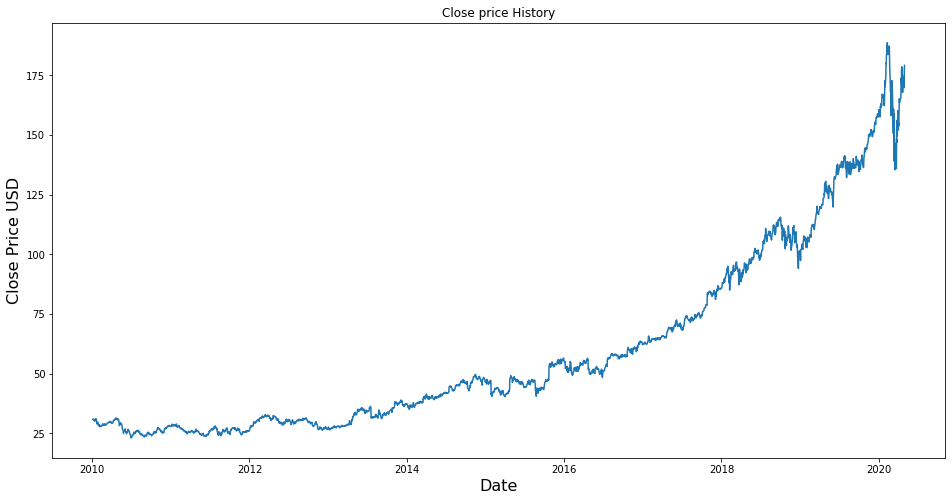

In [3]:
# visualizing close price
plt.figure(figsize= (16,8))
plt.title('Close price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize = 16)
plt.ylabel('Close Price USD', fontsize = 16)
plt.show()

In [4]:
# Creating new data fram with only Close price data
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset)*0.8)
training_data_len

2080

In [5]:
#scaling data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.04792082],
       [0.04798116],
       [0.04683445],
       ...,
       [0.88599191],
       [0.93198138],
       [0.94272442]])

In [6]:
#creating scaled training datasets
train_data = scaled_data[0:training_data_len,:]
x_train = []
y_train = []

for i in range(50, len(train_data)):
  x_train.append(train_data[i-50:i,0])
  y_train.append(train_data[i,0])
  if i<=50:
    print (x_train)
    print (y_train)
    

[array([0.04792082, 0.04798116, 0.04683445, 0.04490314, 0.04617056,
       0.04381677, 0.04260969, 0.0442996 , 0.04798116, 0.04737764,
       0.04882612, 0.04574808, 0.04224757, 0.03591043, 0.03808316,
       0.03916953, 0.04019555, 0.03711751, 0.03120285, 0.03259098,
       0.03289275, 0.03391876, 0.02915082, 0.03023719, 0.02842657,
       0.03017684, 0.03005613, 0.03084073, 0.02969401, 0.03222886,
       0.03367735, 0.03597078, 0.03476372, 0.0345223 , 0.03210815,
       0.03391876, 0.0337377 , 0.03416018, 0.03627256, 0.03289275,
       0.03289275, 0.03391876, 0.03367735, 0.03391876, 0.03494477,
       0.03597078, 0.03723822, 0.0377814 , 0.03790211, 0.03838494])]
[0.03995412555350264]


In [7]:
#converting x_train, y_train in numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
#reshaping data for the LSTM model
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1],1))
x_train.shape

(2030, 50, 1)

In [0]:
#Model build
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(30))
model.add(Dense(1))

In [0]:
#Compling the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
#training the model
model.fit(x_train, y_train, batch_size=1,epochs=1)

Epoch 1/1
2030/2030 [==============================] - 74s 36ms/step - loss: 2.2113e-04


In [11]:
#creating testing dataset 
test_data = scaled_data[training_data_len - 50 : , :]
test_data.shape


(569, 1)

In [0]:
#creating x_test and y_test
x_test = []
y_test = dataset[training_data_len : , : ]
for i in range(50, len(test_data)):
  x_test.append(test_data[i-50 : i, 0])

In [14]:
x_test = np.array(x_test)
x_test.shape

(519, 50)

In [0]:
#reshaping test data
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [0]:
#get models predicted price value
prediction = model.predict(x_test)
prediction = scaler.inverse_transform(prediction)

In [17]:
# calculation RMSE
rmse = np.sqrt(np.mean(prediction - y_test)**2)
rmse

16.288236349763668

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


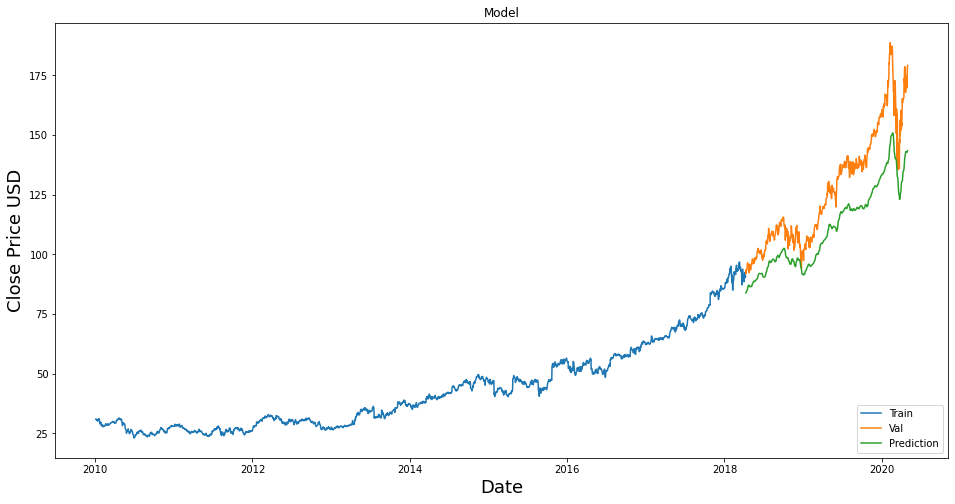

In [18]:
#ploting data
train = data[:training_data_len]
valid = data[training_data_len : ]
valid['Prediction'] = prediction
#visualizing data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD', fontsize = 18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Prediction']])
plt.legend(['Train','Val','Prediction'], loc = 'lower right')
plt.show()

In [19]:
valid

,Close,Prediction
Date,,
2018-04-10,92.879997,83.800247
2018-04-11,91.860001,84.029678
2018-04-12,93.580002,84.201332
2018-04-13,93.080002,84.513962
2018-04-16,94.169998,84.786049
...,...,...
2020-04-24,174.550003,142.815186
2020-04-27,174.050003,142.976837
2020-04-28,169.809998,143.169891


In [20]:
# predicting
msft_quote = web.DataReader('MSFT', data_source='yahoo', start = '2010-01-01', end= '2020-05-20')
new_df = msft_quote.filter(['Close'])
last_50_days = new_df[-50:].values
last_50_days_scaled = scaler.transform(last_50_days)
X_test = []
X_test.append(last_50_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0], X_test.shape[1], 1))
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)


[[149.76685]]


In [21]:
msft_quote2 = web.DataReader('MSFT', data_source='yahoo', start = '2020-05-21', end= '2020-05-21')
print (msft_quote2['Close'])

Date
2020-05-21    183.429993
2020-05-21    183.429993
Name: Close, dtype: float64
